# Axelrod Model of Dissemination of Culture

We are going to simulate the Axelrod model of dissemination of culture from his paper titled "The Dissemination of Culture: A Model with Local Convergence and Global Polarization" (https://journals.sagepub.com/doi/10.1177/0022002797041002001).

In this simulation, we will agent-based framework in python provided by the Mesa framework (https://mesa.readthedocs.io/en/master/).

We modify the model to use randomly generated network instead of the standard square grid here.

After running the simulation, we present the plot that measures trait differences between neighbors for the entire system.

# Model Summary

Consider each people to have $n$ number of cultural features we call as $feature$ that could be represented as political leaning, economic stance, fashion, favorite music, etc. Each of this feature could be classified into $m$ number of traits, for example in economic stance there are possible traits such as marxian, keynesian, etc. They are connected to each other as nodes in a network $G$, where they can only interact with their neighbors.

For each time step:
1. Pick a random agent in the network and one of its neighbor.
2. Measure their feature similarities, and calculate the probability of interaction based on $P = \frac{no. same features}{n}$.
3. If they decide to interact based on the probability, the agent will adopt the neighbor's trait for a random feature where they differ in value (if any).

Based on this simple rules, we will observe how the homogenization will be achieved over time.

# Install MESA

In [0]:
!pip install mesa

     |████████████████████████████████| 634kB 2.6MB/s 
     |████████████████████████████████| 51kB 19.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/0b/e1/a9/8cb6a66246419d8268c559c551a6ea176481003d68168de011
Successfully built mesa


# Imports

In [0]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
from mesa.time import RandomActivation
import numpy as np
import networkx as nx
import random

# Difference Measurement

This is our metric to check whether the model leads to homogenized state of traits or remain  relatively diverse.

$difference = \frac{1}{n} \sum_{(i,j)\in Edges}|feature_i - feature_j|$


In [0]:
def f_difference(model):
    diff = 0
    conn = nx.edges(model.graph)
    for edge in conn:
        diff += np.mean(abs(model.schedule.agents[edge[0]].feature - model.schedule.agents[edge[1]].feature))
    return diff

# Defining the Agent and the Model

We will define the agent and the object model according to Mesa's framework. In this implementation, the action is done under the model's step instead of agent's step because it is simpler to just call one agent at a time using this interaction because the usual Mesa scheduler require every agent to be activated in each time step.

In [0]:
class axl_agent(Agent):
    '''Individual agent represented by a node in a network'''
    
    ## Initializing the agent.
    def __init__(self, unique_id, feat, trt, model):
        super().__init__(unique_id, model)
        self.feature = np.random.randint(low = 0, high = trt, size = feat)
    
    ## No content on agent's step.
    def step(self):
        return
    
class axl_model(Model):
    '''Model containing N agents connected in a network. Also change the value of agent here'''
    
    ##Initializing the model.
    def __init__(self, N, Graph, feat, trt):
        self.graph = Graph
        self.no_features = feat
        self.no_agents = N
        self.G = NetworkGrid(Graph)
        self.schedule = RandomActivation(self)
        
        ## Creating the agents.
        for i in range(self.no_agents):
            a = axl_agent(i, feat, trt, self)
            self.schedule.add(a)
        
        ## Creating collector for difference function defined above.
        self.datacollector = DataCollector(model_reporters = {"Difference" : f_difference})
    
    ## At each model step, they collect data by using the collector.
    def step(self):
        self.datacollector.collect(self)
        agent = random.choice(self.schedule.agents)
        neigh = self.schedule.agents[random.choice(self.G.get_neighbors(agent.unique_id))]
        prob = np.count_nonzero(agent.feature - neigh.feature)/self.no_features
        if np.random.rand() < prob:
            index = np.random.choice(np.nonzero(agent.feature - neigh.feature)[0])
            agent.feature[index] = neigh.feature[index]

# Running the Model

Below are the values required to initialize the model. We use networkx to generate random network.

Feel free to experiment with the parameters.

In [0]:
features = 5
traits = 5
N = 50
P = 0.1
time = 1000
graph = nx.fast_gnp_random_graph(N, P)

Creating the model.

In [0]:
model = axl_model(N, graph, features, traits)

Running the model for give time $T$.

In [0]:
for i in range(time):
    model.step()

# Plotting the Difference over Time

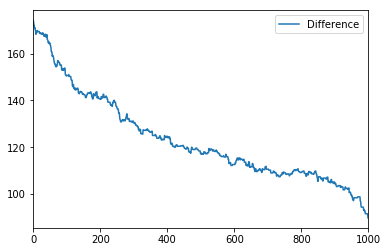

In [0]:
data = model.datacollector.get_model_vars_dataframe()
data.plot()